# Intraday Strategy, Part 2: Model Training & Signal Evaluation

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and use the features engineered in the last notebook to train gradient boosting model that predicts the returns for the NASDAQ100 stocks over the next 1-minute bar. 

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact. This does certainly not reflect market reality, and is rather due to the challenges of simulating a trading strategy at this much higher intraday frequency in a realistic manner using open-source tools.

Note also that this section has slightly changed from the version published in the book to permit replication using the Algoseek data sample.

## Imports & Settings

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/quant_finance/ml_book/Machine-Learning-for-Algorithmic-Trading-Second-Edition/')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

Ensuring we can import `utils.py` in the repo's root directory:

In [ ]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [ ]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [ ]:
# where we stored the features engineered in the previous notebook
data_store = '../data/algoseek.h5'

In [ ]:
# where we'll store the model results
result_store = '../data/intra_day.h5'

In [ ]:
# here we save the trained models
model_path = Path('../models/intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

## Load Model Data

In [ ]:
data = pd.read_hdf(data_store, 'min_taq')

In [ ]:
nasdaq_path = Path('/content/nasdaq100')
path = nasdaq_path
if not path.exists():
      path.mkdir(parents=True)

In [ ]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']
with pd.HDFStore(data_store) as store:
    df = store['min_taq'].loc[:, data_cols].sort_index()

In [ ]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,...,rup,rdown,BOP,CCI,MFI,STOCHRSI,slowd,slowk,NATR,trades_bid_ask
count,3.087565e+06,3.061353e+06,3.030366e+06,3.022232e+06,3.014597e+06,3.006284e+06,2.998549e+06,2.990669e+06,2.982548e+06,2.974617e+06,...,3.008146e+06,3.008146e+06,3.061353e+06,2.851720e+06,3.087377e+06,3.087164e+06,3.087329e+06,3.087329e+06,3.087377e+06,3.008146e+06
mean,1.944517e+02,-2.933200e-06,-1.869810e-06,-1.598179e-06,-1.981696e-06,-1.142065e-06,3.964908e-08,8.709935e-07,1.473304e-06,8.600771e-07,...,5.109800e-01,5.258520e-01,-2.657472e-03,1.926504e-01,4.995851e+01,4.996170e+01,5.026232e+01,5.025505e+01,9.574717e-02,-7.094037e-03
std,1.127876e+02,8.522094e-04,1.143481e-03,1.364755e-03,1.554875e-03,1.717925e-03,1.863826e-03,1.994273e-03,2.115630e-03,2.235502e-03,...,7.497976e+00,3.099559e+01,6.268154e-01,1.088541e+02,1.969340e+01,3.548760e+01,2.770983e+01,2.860330e+01,7.538252e-02,2.717903e+01
min,0.000000e+00,-1.244796e-01,-8.829405e-02,-1.060236e-01,-1.327945e-01,-1.545420e-01,-1.956444e-01,-2.158158e-01,-1.726063e-01,-2.157102e-01,...,0.000000e+00,0.000000e+00,-1.000000e+00,-4.666667e+02,-1.837897e-08,0.000000e+00,-3.910354e-12,-5.092223e-12,2.026288e-07,-2.630100e+04
10%,3.800000e+01,-7.494558e-04,-1.048584e-03,-1.268377e-03,-1.454229e-03,-1.616089e-03,-1.762741e-03,-1.897606e-03,-2.026686e-03,-2.142857e-03,...,0.000000e+00,0.000000e+00,-9.000000e-01,-1.377555e+02,2.395492e+01,0.000000e+00,1.250572e+01,1.122968e+01,4.014445e-02,-7.299035e-01
20%,7.700000e+01,-4.105090e-04,-5.929791e-04,-7.232152e-04,-8.290892e-04,-9.218753e-04,-1.004307e-03,-1.081334e-03,-1.153403e-03,-1.218621e-03,...,9.638554e-02,9.944259e-02,-6.644518e-01,-9.983731e+01,3.237073e+01,9.771635e+00,2.094136e+01,1.994344e+01,4.871973e-02,-4.601227e-01
30%,1.160000e+02,-2.308225e-04,-3.375865e-04,-4.100041e-04,-4.732608e-04,-5.260389e-04,-5.755245e-04,-6.196361e-04,-6.601532e-04,-6.987242e-04,...,1.976744e-01,2.017393e-01,-4.508475e-01,-6.917500e+01,3.883638e+01,2.365167e+01,3.006536e+01,2.936605e+01,5.665948e-02,-2.782861e-01
40%,1.550000e+02,-9.680542e-05,-1.555210e-04,-1.871257e-04,-2.161311e-04,-2.398082e-04,-2.604845e-04,-2.820079e-04,-3.003003e-04,-3.175107e-04,...,2.857143e-01,2.916667e-01,-1.826087e-01,-3.702543e+01,4.452486e+01,3.687606e+01,3.997666e+01,3.958910e+01,6.520095e-02,-1.309554e-01
50%,1.940000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.701016e-01,3.759077e-01,0.000000e+00,4.377638e-01,4.989353e+01,4.993994e+01,5.029630e+01,5.008741e+01,7.514502e-02,0.000000e+00
60%,2.340000e+02,9.104980e-05,1.499700e-04,1.805591e-04,2.082899e-04,2.328158e-04,2.537642e-04,2.754062e-04,2.960551e-04,3.132832e-04,...,4.578505e-01,4.638802e-01,1.666667e-01,3.785810e+01,5.529671e+01,6.304218e+01,6.069305e+01,6.111111e+01,8.752835e-02,1.036810e-01


In [ ]:
df['date'] = pd.to_datetime(df.index.get_level_values('date_time').date)

In [ ]:
df.to_hdf(nasdaq_path / 'algoseek.h5', 'data')

In [ ]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

In [ ]:
data = pd.DataFrame(index=df.index)

In [ ]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [ ]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

In [ ]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

In [ ]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,first,last
ticker,date_time,,,,,
TSCO,2016-12-22 10:01:00,498,31,0.133921,68.1000,77.2200
AMGN,2017-03-06 15:46:00,546,376,0.132842,158.7600,179.8500
LILA,2015-07-02 09:39:00,125,9,0.121998,50.0001,56.1000
BIDU,2015-08-24 09:32:00,161,2,0.119729,111.2300,124.5475
NXPI,2016-09-29 13:10:00,439,220,0.119144,81.7500,91.4900
HSIC,2015-10-26 15:38:00,205,368,0.105501,135.0700,149.3200
CELG,2015-08-24 09:35:00,161,5,0.100645,93.0000,102.3600
LILAK,2015-07-02 09:38:00,125,8,0.098778,50.0101,54.9500
CTRP,2017-12-11 10:51:00,741,81,0.097899,43.3100,47.5500


In [ ]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|██████████| 9/9 [00:39<00:00,  4.42s/it]


In [ ]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [ ]:
data = data.dropna(subset=['fwd1min'])

In [ ]:
for f in ['up', 'down', 'rup', 'rdown']:
    data[f] = df.loc[:, f].div(df.volume).replace(np.inf, np.nan)

In [ ]:
#! sudo apt install build-essential wget -y
! wget https://artiya4u.keybase.pub/TA-lib/ta-lib-0.4.0-src.tar.gz
! tar -xvf ta-lib-0.4.0-src.tar.gz


--2023-02-24 13:10:02--  https://artiya4u.keybase.pub/TA-lib/ta-lib-0.4.0-src.tar.gz
Resolving artiya4u.keybase.pub (artiya4u.keybase.pub)... 54.161.52.108, 3.227.27.101, 54.87.208.206, ...
Connecting to artiya4u.keybase.pub (artiya4u.keybase.pub)|54.161.52.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330299 (1.3M) [application/gzip]
Saving to: ‘ta-lib-0.4.0-src.tar.gz’

ta-lib-0.4.0-src.ta 100%[===================>]   1.27M  2.59MB/s    in 0.5s    

2023-02-24 13:10:05 (2.59 MB/s) - ‘ta-lib-0.4.0-src.tar.gz’ saved [1330299/1330299]

ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-l

In [ ]:
! mv ta-lib /content/ta-lib
! cd /content/ta-lib/ && ./configure --prefix=/usr && make && sudo make install

checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /usr/bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking for gcc... gcc
checking for C compiler default output file name... a.out
checking whether the C compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking for style of include used by make... GNU
checking dependency style of gcc... gcc3
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking for a sed that does not truncate output... /usr/bin/sed
checking for grep that handles long lines and -e... /usr/bin/grep
chec

In [ ]:
! sudo pip install TA-Lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached TA-Lib-0.4.25.tar.gz (271 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TA-Lib: filename=TA_Lib-0.4.25-cp38-cp38-linux_x86_64.whl size=2510012 sha256=142b1e1ff0f134fce16b6d9bdb2e7b03dfbf3645d6e6b4985e0eee2dbd67d275
  Stored in directory: /root/.cache/pip/wheels/da/72/bf/464831127ee8d6d9a5b76340a6a2f115182e159309dc3067ca
Successfully built TA-Lib


In [ ]:
import talib

In [ ]:
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x['first'],
                                                   x.high,
                                                   x.low,
                                                   x['last'])))

In [ ]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14)))

In [ ]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)))

In [ ]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'].ffill(),
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

In [ ]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high.ffill(), x.low.ffill(), x['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
    return pd.DataFrame({'slowd': slowd, 
                         'slowk': slowk}, 
                        index=x.index)

In [ ]:
data = data.join(by_ticker.apply(compute_stoch))

In [ ]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high.ffill(), 
                                                    x.low.ffill(), 
                                                    x['last'].ffill()))

In [ ]:
data['trades_bid_ask'] = df.atask.sub(df.atbid).div(df.volume).replace((np.inf, -np.inf), np.nan)

In [ ]:
del df

In [ ]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min',
            'rup', 'up', 'down', 'rdown', 'BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd', 'trades_bid_ask']

In [ ]:
sample = data.sample(n=100000)

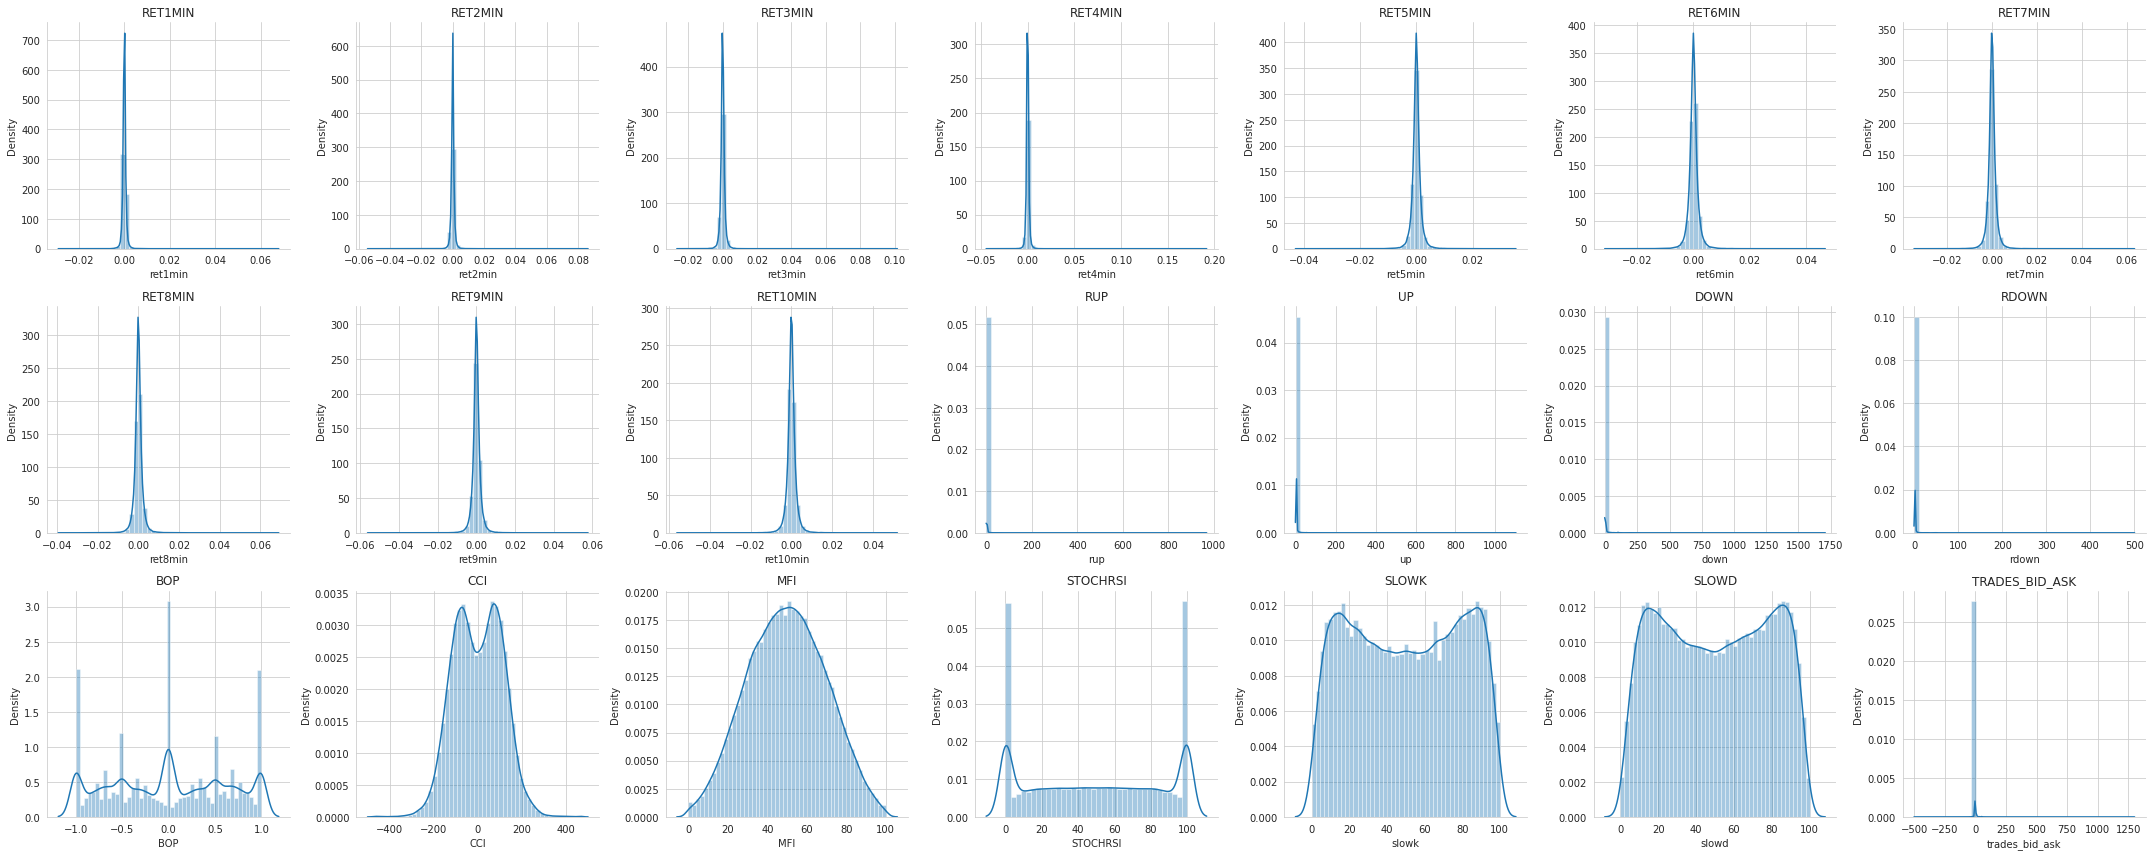

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

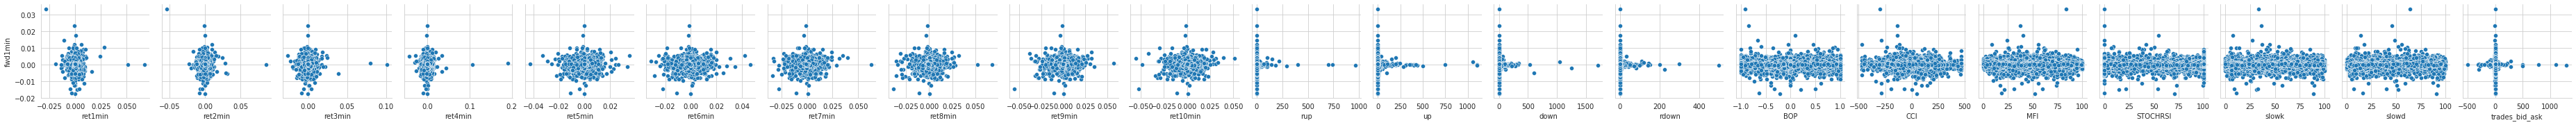

In [ ]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features);

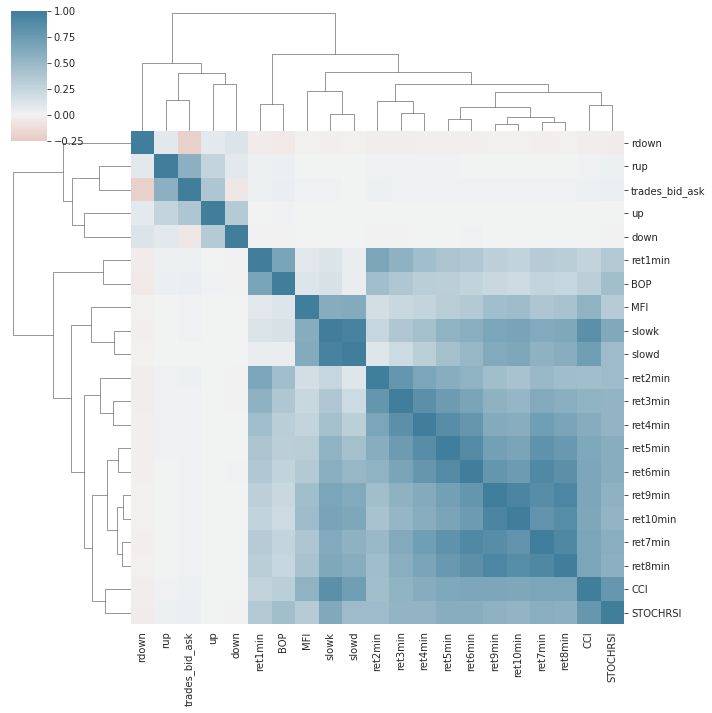

In [ ]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [ ]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('date_time').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████| 21/21 [06:55<00:00, 19.80s/it]


In [ ]:
ic.sort_values()

STOCHRSI         -0.015177
ret4min          -0.013636
CCI              -0.012663
ret5min          -0.012534
ret3min          -0.012235
ret9min          -0.010546
ret8min          -0.009978
ret2min          -0.009834
ret7min          -0.009678
ret10min         -0.009596
ret1min          -0.009468
ret6min          -0.009047
rup              -0.008965
BOP              -0.006312
slowk            -0.005720
trades_bid_ask   -0.005406
MFI              -0.003847
slowd            -0.001772
up               -0.000832
down              0.000038
rdown             0.010978
dtype: float64

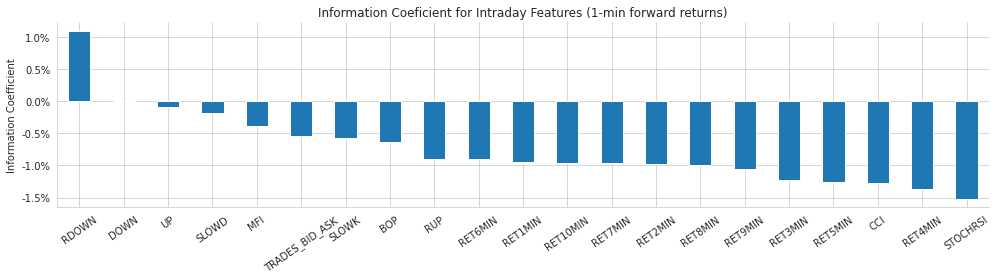

In [ ]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

In [ ]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 25 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date            30875649 non-null  int64  
 1   minute          30875649 non-null  int64  
 2   ret1min         30612848 non-null  float64
 3   ret2min         30302846 non-null  float64
 4   ret3min         30220887 non-null  float64
 5   ret4min         30141503 non-null  float64
 6   ret5min         30063236 non-null  float64
 7   ret6min         29983969 non-null  float64
 8   ret7min         29903822 non-null  float64
 9   ret8min         29824607 non-null  float64
 10  ret9min         29745431 non-null  float64
 11  ret10min        29666821 non-null  float64
 12  fwd1min         30875649 non-null  float64
 13  up              30083777 non-null  float64
 14  down            30083777 non-null  flo

In [ ]:
data.drop(['date', 'up', 'down'], axis=1).to_hdf('../data/algoseek_small.h5', 'model_data')

In [ ]:
! ls -lrth ../data/algoseek_small.h5

-rw------- 1 root root 5.3G Feb 24 13:44 ../data/algoseek_small.h5
